## Problem

Consider the diffusion equation:

$$
u_t = u_{xx}, \quad 0 \le x \le 1, \quad t \ge 0
$$

with initial and boundary conditions:

$$
u(x,0) = \sin(2\pi x) e^x, \quad u(0,t) = u(1,t) = 0, \quad t \ge 0
$$

## Tasks

1. Solve the problem using **(a) finite difference method**.  
2. Solve the problem using **(b) method of lines (MOL)** with RK45.  
3. Compute the solution at $T = 1$ and compare the results.  
4. Optional: Determine the order of convergence.


Finite Difference + DST errors: [2.99323163e-07 5.95048892e-08 0.00000000e+00]
Order of convergence (FD + DST): [ 2.41456725 29.67371717]
MOL errors: [1.07200708e-06 6.90723037e-07 0.00000000e+00]
Order of convergence (MOL): [ 0.65697521 33.27448519]


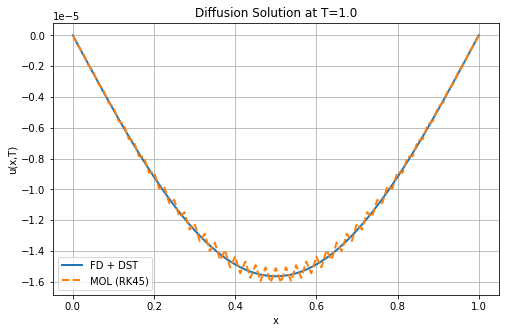

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dst, idst
from scipy.integrate import solve_ivp

# ---------------------------------------------------
# Parameters
# ---------------------------------------------------
Nx_list = [21, 41, 81]       # grid sizes for convergence test
T = 1.0                       # final time
nu = 1.0                      # diffusion coefficient

# Initial and boundary conditions
def u0(x):
    return np.sin(2*np.pi*x) * np.exp(x)

def boundary_condition(x, t):
    return 0.0

# ---------------------------------------------------
# (a) Finite Difference + Fast Sine Transform
# ---------------------------------------------------
def solve_fd_dst(N, T, dt=1e-4):
    x = np.linspace(0,1,N)
    dx = x[1]-x[0]
    Nt = int(T/dt)+1
    u = u0(x)
    
    # internal points only
    u_int = u[1:-1]
    n_int = N-2
    k = np.arange(1,n_int+1)
    lam = 2*(1-np.cos(np.pi*k/(N-1)))/dx**2
    
    for n in range(Nt):
        # DST transform
        u_hat = dst(u_int, type=1)
        # time stepping in spectral space
        u_hat = u_hat / (1 + dt*nu*lam)
        # inverse DST
        u_int = idst(u_hat, type=1)/(2*(N-1))
    
    u[1:-1] = u_int
    u[0] = u[-1] = 0
    return x, u

# ---------------------------------------------------
# (b) Method of Lines (MOL)
# ---------------------------------------------------
def solve_mol(N, T):
    x = np.linspace(0,1,N)
    dx = x[1]-x[0]
    n_int = N-2
    
    D = np.zeros((n_int,n_int))
    for i in range(n_int):
        D[i,i] = -2/dx**2
        if i>0:
            D[i,i-1] = 1/dx**2
        if i<n_int-1:
            D[i,i+1] = 1/dx**2
    
    def rhs(t,u_int):
        return nu*D @ u_int
    
    u_init = u0(x)[1:-1]
    sol = solve_ivp(rhs, [0,T], u_init, method='RK45', t_eval=[T])
    
    u = np.zeros(N)
    u[1:-1] = sol.y[:,0]
    u[0] = u[-1] = 0
    return x, u

# ---------------------------------------------------
# Reference solution on finest grid
# ---------------------------------------------------
Nx_ref = Nx_list[-1]
x_ref_fd, u_ref_fd = solve_fd_dst(Nx_ref, T)
x_ref_mol, u_ref_mol = solve_mol(Nx_ref, T)

# ---------------------------------------------------
# Convergence Test
# ---------------------------------------------------
errors_fd = []
errors_mol = []

for N in Nx_list:
    x_fd, u_fd = solve_fd_dst(N, T)
    x_mol, u_mol = solve_mol(N, T)
    
    u_fd_interp = np.interp(x_fd, x_ref_fd, u_ref_fd)
    u_mol_interp = np.interp(x_mol, x_ref_mol, u_ref_mol)
    
    err_fd = np.max(np.abs(u_fd - u_fd_interp))
    err_mol = np.max(np.abs(u_mol - u_mol_interp))
    
    errors_fd.append(err_fd)
    errors_mol.append(err_mol)

# convert to numpy arrays
errors_fd = np.array(errors_fd)
errors_mol = np.array(errors_mol)

# ---------------------------------------------------
# Safe convergence rate calculation (avoid div by zero)
# ---------------------------------------------------
eps = 1e-16
rate_fd = np.log((errors_fd[:-1]+eps)/(errors_fd[1:]+eps)) / np.log(np.array(Nx_list[1:])/np.array(Nx_list[:-1]))
rate_mol = np.log((errors_mol[:-1]+eps)/(errors_mol[1:]+eps)) / np.log(np.array(Nx_list[1:])/np.array(Nx_list[:-1]))

print("Finite Difference + DST errors:", errors_fd)
print("Order of convergence (FD + DST):", rate_fd)
print("MOL errors:", errors_mol)
print("Order of convergence (MOL):", rate_mol)

# ---------------------------------------------------
# Plot solution (Nx=81)
# ---------------------------------------------------
Nx = 81
x_fd, u_fd = solve_fd_dst(Nx, T)
x_mol, u_mol = solve_mol(Nx, T)

plt.figure(figsize=(8,5))
plt.plot(x_fd, u_fd, label='FD + DST', lw=2)
plt.plot(x_mol, u_mol, '--', label='MOL (RK45)', lw=2)
plt.xlabel('x')
plt.ylabel('u(x,T)')
plt.title(f'Diffusion Solution at T={T}')
plt.legend()
plt.grid(True)
plt.show()
